# 1. Business Understanding

When selling a house, the price is one of the most important factors for both buyers and sellers. For sellers, setting the right price can help them sell their house faster and for a better price. For buyers, understanding the factors that influence house prices can help them make informed decisions when purchasing a property. In this project, real estate valuation data will be used to build predictive models for house prices. Both a linear regression model and a logistic regression model will be used to predict house prices. The goal is to make models that can generalize well to unseen data and make accurate predictions of house prices based on the features in the dataset.

The requirements for this project include understanding the dataset, preprocessing the data, building and evaluating the linear and logistic regression models and interpreting the results. The expected outcome is to have a good understanding of the factors that influence house prices and to have predictive models that can estimate house prices with good accuracy. What restricts the models are the amount of features in the dataset and the complexity of the real estate market. Many other factors than the ones in the dataset can influence house prices, such as economic conditions, local market trends and possible renovations done or planned for the properties. Therefore, the models may not capture all the variability in house prices, but they can still provide useful insights and predictions based on the features available in the dataset.

# 2. Data Understanding

The dataset is from the UCI Machine Learning Repository and contains information about real estate valuations in Taipei, Taiwan.

There are 6 features in the dataset, which are:
1. X1: transaction date (fractional year, for example, 2013.250 = 2013 March, 2013.500 = 2013 June, etc.)
2. X2: house age (unit: year)
3. X3: distance to the nearest MRT station (unit: meter)
4. X4: number of convenience stores in the living circle on foot (integer)
5. X5: latitude (unit: degree)
6. X6: longitude (unit: degree)

The target variable is Y, which is the house price of unit area (unit: New Taiwan Dollar per ping, where 1 ping = 3.3 square meters).

According to the dataset description, there are no missing values, outliers or nonsensical values in the dataset. However, the dataset includes an ID column that is not relevant for data analysis and regression modeling. There are 414 entries in the dataset. 

In the scatter plots below the dataset information, the relationships between the features and the target variable are visualized. The scatter plots show that each feature has a visible relationship with the target variable although in some cases the relationship is not visibly linear. Most show clear trends, such as prices decreasing with the distance to the nearest metro station and increasing with the number of convenience stores. Features X1 and X4 show a blocky relationship because of the way the features are structured (X1 is a fractional year and X4 is an integer). Especially after standardization, the dataset is suitable for linear and logistic regression modeling.

In the code cells below, the dataset is loaded and the features and target variable are separated. Some information on the dataset is printed and a scatter plot is created to visualize the relationships between the features and the target variable. In the first code cell, all the necessary libraries are imported. This analysis uses scikit-learn for modeling and evaluation and matplotlib for visualization.

In [279]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_absolute_error, r2_score, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance

real_estate_valuation = fetch_ucirepo(id=477)
# data (as a pandas dataframe)
X = real_estate_valuation.data.original

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [280]:
X.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


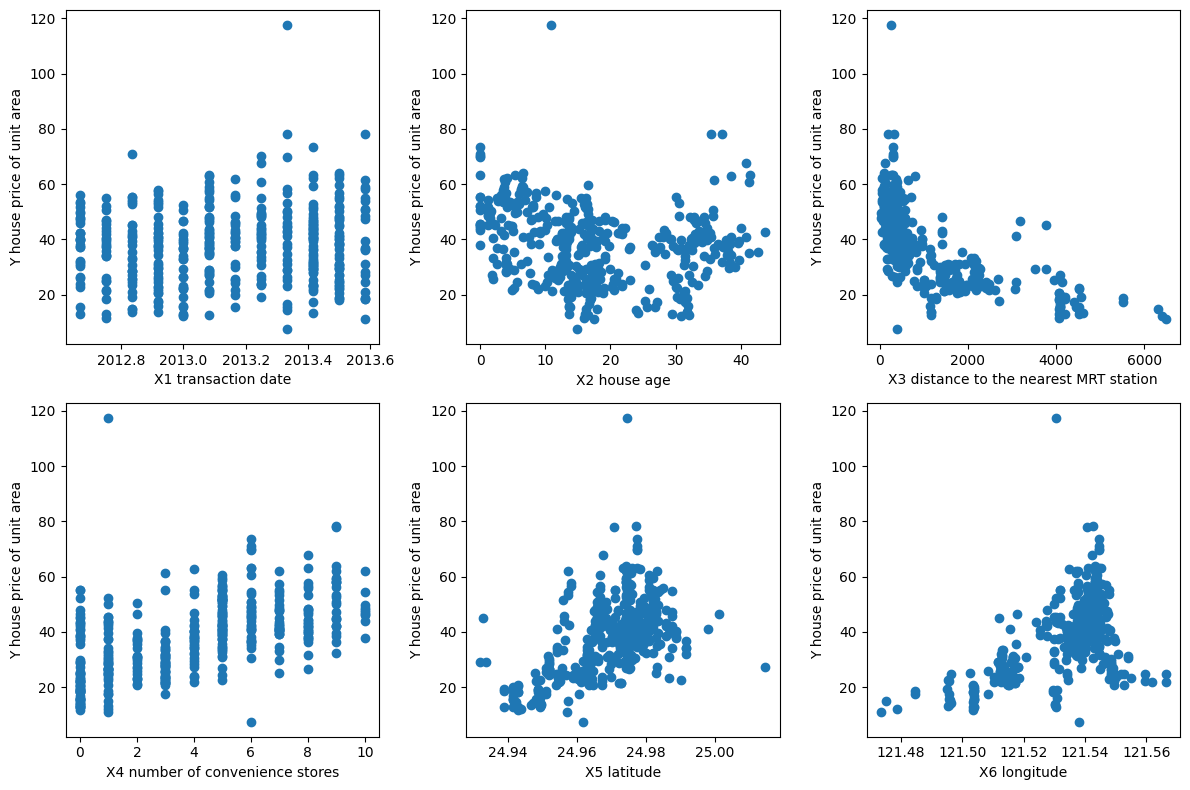

In [281]:
# Plotting the features against the target variable to visualize the relationships

target = 'Y house price of unit area'

features = [
    'X1 transaction date',
    'X2 house age',
    'X3 distance to the nearest MRT station',
    'X4 number of convenience stores',
    'X5 latitude',
    'X6 longitude'
]

plt.figure(figsize=(12, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(X[feature], X[target])
    plt.xlabel(feature)
    plt.ylabel(target)

plt.tight_layout()
plt.show()

# 3. Data Preparation

The ID column (named 'No') is not relevant for data analysis and regression modeling, so it will be dropped from the dataset. The data is split into features (X) and target variable (y). The data is then split into training and testing sets with a 70-30 split. Both the linear and logistic regression models will need to be trained on a scaled version of the data, so the features will be standardized using StandardScaler from scikit-learn. Training data will be standardized using the fit_transform method, while testing data will be standardized using the transform method to ensure that the same scaling is applied to both sets and the test data is not used to fit the scaler. 

Regression models could work with unstandardized data, but it is generally recommended to standardize the features to improve the performance of the models. This also makes them more robust and easier to interpret. 

Both models will use the same standardized training and testing data, but the target variable will be treated differently for each model. Logistic regression needs a binary target variable and as the dataset´s target variable is not, it will be transformed into a binary variable by dividing the target variable into two classes based on a threshold value. The threshold value will set as the average price of the target variable in the whole dataset. All entries with a target variable value above the average price will be classified as 1 (high price), and all entries with a target variable value below the average price will be classified as 0 (low price).

The class distributions of the training and testing sets are checked to ensure the classes are reasonably balanced. The class distribution is reasonably balanced in both sets, with a slightly higher proportion of high price entries in both the training and testing sets.

In [282]:
# Drop the ID column, split training and testing data
X = X.drop(columns=['No'])
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=[target]), X[target], test_size=0.3, random_state=123)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Target variable made binary for logistic regression in training and testing sets. Average calculated from the whole dataset to ensure the same threshold is used for both sets.
average_price = X[target].mean()
y_train_class = (y_train > average_price).astype(int)
y_test_class = (y_test > average_price).astype(int)
print(f"Average price: {average_price:.2f} Dollar per ping\n")
print(f"Training set class distribution:\n{y_train_class.value_counts()}\n")
print(f"Testing set class distribution:\n{y_test_class.value_counts()}\n")

Average price: 37.98 Dollar per ping

Training set class distribution:
Y house price of unit area
1    150
0    139
Name: count, dtype: int64

Testing set class distribution:
Y house price of unit area
1    64
0    61
Name: count, dtype: int64



# 4. Modeling

The modeling process for both the linear and logistic regression models are described in this section. The linear regression model is trained using the original target variable (house price), while the logistic regression model is trained using the binary target variable (high price vs low price). Both models are trained on the same standardized training data. Both models are then evaluated in the next section.

### Linear Regression

The linear regression model is trained using the LinearRegression class from scikit-learn. 

In [283]:
# Train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Trained values of the coefficients
print("Linear Regression Coefficients:")
for feature, coef in zip(features, linear_model.coef_):
    print(f"{feature}: {coef:.4f}")

Linear Regression Coefficients:
X1 transaction date: 1.5032
X2 house age: -3.0049
X3 distance to the nearest MRT station: -6.0670
X4 number of convenience stores: 3.1549
X5 latitude: 2.7356
X6 longitude: -0.4031


The coefficients tell us how much each feature affects the target variable. A positive coefficient means that as the feature increases, the target variable also increases, while a negative coefficient means that as the feature increases, the target variable decreases. The magnitude of the coefficient gives an idea of which features have stronger effects on the target as the data is standardized and as such is comparable. 

The feature that seems to affect the target the most is the distance to the nearest MRT station (X3), which has a negative coefficient, indicating that as the distance to the nearest MRT station increases, the house price decreases. The number of convenience stores (X4) has a positive coefficient, indicating that as the number of convenience stores increases, the house price also increases. The least influential feature seems to be the longitude (X6), which has a very small negative coefficient indicating that it has a very small negative effect on the house price. 

### Logistic Regression

The logistic regression model is trained using the LogisticRegression class from scikit-learn.

In [284]:
# Train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train_class)

# Trained values of the coefficients
print("\nLogistic Regression Coefficients:")
for feature, coef in zip(features, logistic_model.coef_[0]):
    print(f"{feature}: {coef:.4f}")



Logistic Regression Coefficients:
X1 transaction date: 0.3602
X2 house age: -0.7147
X3 distance to the nearest MRT station: -2.3555
X4 number of convenience stores: 0.6579
X5 latitude: 1.1064
X6 longitude: 0.2827


As in the linear regression model, the magnitude and the sign of the coefficients indicate the strength and direction of the relationship between each feature and the target variable. Here the target variable is binary (high price vs low price).  A positive coefficient means that as the feature increases, the likelihood of the house being classified as high price increases, while a negative coefficient means that as the feature increases, the likelihood of the house being classified as high price decreases.

The feature that seems to affect the target the most is again the distance to the nearest MRT station (X3), which has a negative coefficient, indicating that as the distance to the nearest MRT station increases, the likelihood of the house being classified as high price decreases. The number of convenience stores (X4) still has a positive coefficient, indicating that as the number of convenience stores increases, the likelihood of the house being classified as high price also increases. In this model however, the latitude (X5) and house age (X2) seem to have stronger effects on the target variable than number of convenience stores. 

The magnitudes of the coefficients in the logistic regression model are slighter than in the linear regression model, which is expected as the target variable is binary and the coefficients represent log-odds rather than direct changes in the target variable. Log-odds mean that the coefficients represent the change in the log-odds of the target variable being classified as high price for a one-unit increase in the feature variable, while in linear regression the coefficients represent the change in the target variable (house price) for a one-unit increase in the feature variable.

**Logistic Regression Model for High House Price**

Let $X_1$ to $X_6$ be the standardized features:  
transaction date ($X_1$), house age ($X_2$), distance to nearest MRT ($X_3$), number of convenience stores ($X_4$), latitude ($X_5$), and longitude ($X_6$).

**Linear combination (logit):**

$$
z = 0.36 X_1 - 0.71 X_2 - 2.36 X_3 + 0.66 X_4 + 1.11 X_5 + 0.28 X_6
$$

If $z$ is positive, the model predicts a higher probability of the house being classified as high price, while if $z$ is negative, the model predicts a lower probability of the house being classified as high price.

**Probability of high price:**

$$
P(\text{High Price}) = \frac{1}{1 + e^{-z}}
$$


**Decision rule (binary classifier):**  
- If $P(\text{High Price}) \ge 0.5$, predict high price (1)  
- If $P(\text{High Price}) < 0.5$, predict low price (0)


To complement the coefficient interpretaion, the model´s permutation feature importance is also calculated. This measures the effect of each feature on the model´s predictive performance by randomly shuffling a feature´s values and measuring the decrease in model performance. The feature with the highest decrease in performance is considered the most important. The calculations are done using the test set to ensure that the importance is measured on unseen data. The n_repeats parameter is set to 10 to get a more robust estimate of feature importance, and the scoring parameter is set to "accuracy" to measure the decrease in accuracy when each feature is shuffled. The results are visualized using a boxplot, which shows the distribution of importance scores for each feature across the 10 repeats. The features are sorted by their mean importance score, with the most important feature at the top. n_jobs is set to -1 to use all available CPU cores for the computation, which can speed up the process when working with larger datasets. 

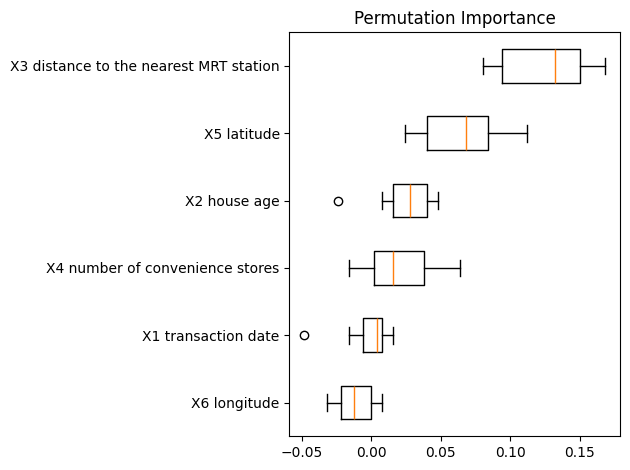

In [285]:
# Permutation importance for logistic regression
result = permutation_importance(logistic_model, X_test_scaled, y_test_class, n_repeats=10, scoring="accuracy", random_state=123, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

The size of the box in the permutation importance plot indicates the variability of the importance scores across the 10 repeats. A larger box indicates more variability, while a smaller box indicates less variability. The position of the box along the x-axis indicates the mean importance score for each feature, with features further to the right being more important for the model's predictions. Again, the distance to the nearest MRT station (X3) is the most important feature, followed by latitude (X5) and house age (X2) as when comparing the logistic regression coefficients. The number of convenience stores (X4) is also important, while transaction date (X1) and longitude (X6) are less important for the model's predictions.

# 5. Evaluation

Both the linear and logistic models are evaluated in this section. Both models are evaluated using the testing data, which was not used in the training phase. The performance of the models is evaluated using appropriate metrics for each model type. The logistic model needs to be evaluated using the binary target variable. 

### Linear Regression

The linear regression model is evaluated using the Mean Absolute Error (MAE) metrics and looking at the residuals. 


Linear Regression Mean Absolute Error: 5.35
Training set residuals mean: 0.00, std: 9.39
Testing set residuals mean: -0.26, std: 7.26


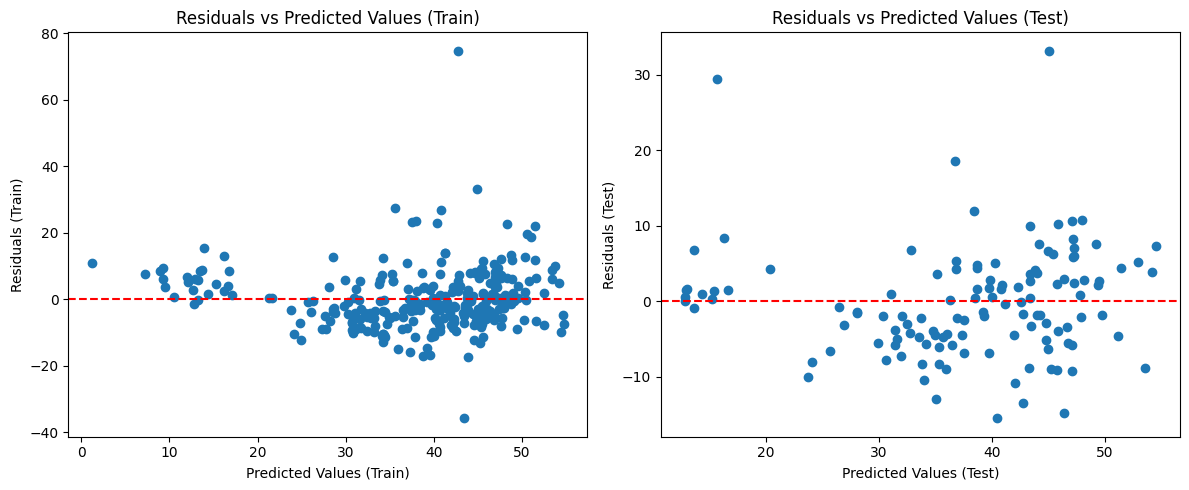

In [286]:
# Mean Absolute Error for linear regression
y_pred_linear = linear_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred_linear)
print(f"\nLinear Regression Mean Absolute Error: {mae:.2f}")

# Plot residuals for linear regression for training and testing data

residuals_train = y_train - linear_model.predict(X_train_scaled)
residuals_test = y_test - y_pred_linear
print(f"Training set residuals mean: {residuals_train.mean():.2f}, std: {residuals_train.std():.2f}")
print(f"Testing set residuals mean: {residuals_test.mean():.2f}, std: {residuals_test.std():.2f}")
# Plot side by side
plt.figure(figsize=(12, 5))

# Residuals vs Predicted Values for training data
plt.subplot(1, 2, 1)
plt.scatter(linear_model.predict(X_train_scaled), residuals_train)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (Train)')
plt.ylabel('Residuals (Train)')
plt.title('Residuals vs Predicted Values (Train)')

# Residuals vs Predicted Values for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_pred_linear, residuals_test)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (Test)')
plt.ylabel('Residuals (Test)')
plt.title('Residuals vs Predicted Values (Test)')
plt.tight_layout()
plt.show()

The MAE of 5.35 indicates that on average, the model's predictions are off by about 5.35 units of the target variable (house price in Dollars per ping). In the scale of the target variable, this is a relatively small error, suggesting that the model has good predictive performance. A smaller value of MAE would indicate better performance, while a larger value would indicate worse performance.

The mean for the residuals for both the training and testing data is close to zero, which is a good sign as it indicates that the model does not have a systematic bias in its predictions. The standard deviation is higher than MAE, which indicates some variability in the residuals. Overall, the residuals do not show any clear patterns, which suggests that the model is fitting the data reasonably well. The fact that the residuals are more spread out for the testing data than for the training data is a good sign, as it indicates that the model is not overfitting to the training data and is able to generalize to unseen data. 

Linear regression models can also be evaluated using the R-squared (R²) metric, which represents the proportion of the variance in the target variable that is explained by the features in the model. An R² value close to 1 indicates that the model explains a large portion of the variance in the target variable. So if simplified, a higher R² value indicates a better fit of the model to the data, while a lower R² value indicates a poorer fit.

For this model the R² value is 0.6731, which indicates that the model explains about 67% of the variance in the target variable. The remaining 33% of the variance is not explained by the model, which suggests that there may be other factors influencing house prices that are not captured by the features in the model. R² value could be improved by adding more relevant features to the model or by using a more complex modeling technique. However, an R² value of 0.6731 is generally considered to be a good fit for a linear regression model, especially in the context of real estate price prediction where there are many factors that can influence prices. This means that in fact a much higher R² value might suggest overfitting, so the current R² value indicates a good balance between model complexity and predictive performance.


In [287]:
# R-squared for linear regression
r2 = r2_score(y_test, y_pred_linear)
print(f"Linear Regression R-squared: {r2:.4f}")

Linear Regression R-squared: 0.6731



### Logistic Regression

The evaluation of the logistic regression model is done using classification metrics such as accuracy and a confusion matrix. These are calculated from the testing data, which was not used in the training phase. The accuracy of the model is calculated as the proportion of correct predictions (both true positives and true negatives) out of the total number of predictions. The confusion matrix provides a more detailed breakdown of the model's performance by showing the counts of true positives, true negatives, false positives, and false negatives.

A 10-fold cross validation is performed on the training data to evaluate the model's performance and to check for overfitting. Cross-validation helps to ensure that the model's performance is consistent across different subsets of the training data and can provide a more reliable estimate of the model's generalization performance on unseen data. If the cross-validation results show that the model performs well across all folds, it suggests that the model is not overfitting and is likely to perform well on new data.


Logistic Regression Cross-Validation Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       139
           1       0.80      0.88      0.84       150

    accuracy                           0.83       289
   macro avg       0.83      0.82      0.83       289
weighted avg       0.83      0.83      0.83       289

CV Accuracy: 0.8270

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81        61
           1       0.81      0.86      0.83        64

    accuracy                           0.82       125
   macro avg       0.83      0.82      0.82       125
weighted avg       0.83      0.82      0.82       125

Test Accuracy: 0.8240


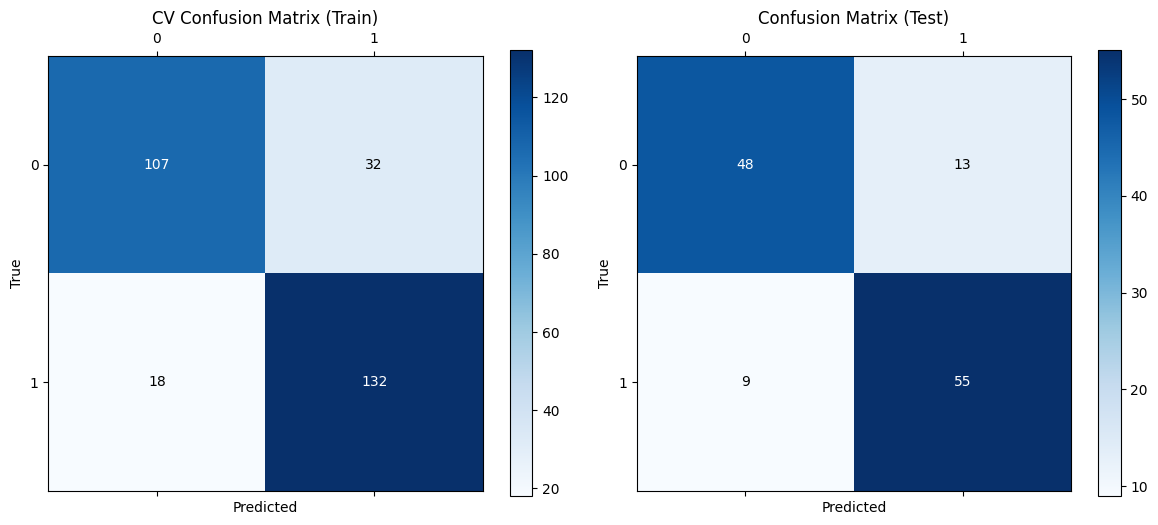

In [288]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_predict

# Cross-validated predictions on training set
y_pred_logistic_cv = cross_val_predict(logistic_model, X_train_scaled, y_train_class, cv=10)

# Print metrics for CV
print("\nLogistic Regression Cross-Validation Classification Report:")
print(classification_report(y_train_class, y_pred_logistic_cv))
accuracy_cv = accuracy_score(y_train_class, y_pred_logistic_cv)
print(f"CV Accuracy: {accuracy_cv:.4f}")

# Predictions on test set
y_pred_test = logistic_model.predict(X_test_scaled)
print("\nLogistic Regression Test Classification Report:")
print(classification_report(y_test_class, y_pred_test))
accuracy_test = accuracy_score(y_test_class, y_pred_test)
print(f"Test Accuracy: {accuracy_test:.4f}")

#  Confusion matrices
cm_cv = confusion_matrix(y_train_class, y_pred_logistic_cv)
cm_test = confusion_matrix(y_test_class, y_pred_test)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# CV confusion matrix
im0 = axes[0].matshow(cm_cv, cmap=plt.cm.Blues)
for i in range(cm_cv.shape[0]):
    for j in range(cm_cv.shape[1]):
        color = "white" if cm_cv[i, j] > cm_cv.max()/2 else "black"
        axes[0].text(j, i, cm_cv[i, j], ha='center', va='center', color=color)
axes[0].set_title('CV Confusion Matrix (Train)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
fig.colorbar(im0, ax=axes[0])

# Test confusion matrix
im1 = axes[1].matshow(cm_test, cmap=plt.cm.Blues)
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        color = "white" if cm_test[i, j] > cm_test.max()/2 else "black"
        axes[1].text(j, i, cm_test[i, j], ha='center', va='center', color=color)
axes[1].set_title('Confusion Matrix (Test)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


The classification reports for test and cross-validated predictions show almost the same values for precision, recall and accuracy. This indicates that the model is not overfitting as it performs consistently on both the training and testing data. The accuracy of the model is around 0.82, which means that the model correctly classifies about 82% of the instances in the test set. As the features describing the dataset are limited this can be considered a good performance for a logistic regression model. The confusion matrices for both cross-validated predictions and test predictions show that the model is able to correctly classify a majority of the instances in both classes (high price and low price), which further supports the conclusion that the model is performing well and is not overfitting. There are some misclassifications, but as previously mentioned, the real estate market is complex and there are many more factors that can influence on the house prices. 

### Summary of Evaluation

Both the linear and logistic regression models perform well on the testing data, which suggests that they are able to generalize to unseen data. The linear regression model has a relatively low MAE and a good R² value, while the logistic regression model has a good accuracy and consistent performance across cross-validation and testing data. The evaluation results suggest that both models are suitable for predicting house prices based on the features in the dataset, although there may be other factors influencing house prices that are not captured by the models.

# 6. Deployment

Both the linear and logistic regression models can be deployed in practice to predict house prices based on the features in the dataset. The linear regression model can be used to predict the actual price of a house, while the logistic regression model can be used to classify houses as high price or low price based on a threshold. This could be used by real estate agents, buyers and sellers to make informed decisions about house pricing and which features of a property are most influential in determining its price. The results of the models can be communicated through visualizations, reports or a user-friendly interface that allows users to input the features of a house and receive predictions for the price or classification. The models can also be further improved by adding more features that are relevant to house prices, such as the size of the house, the number of bedrooms and bathrooms and the condition of the property. As the real estate market is complex and influenced by many factors, it is important to continuously evaluate and update the models to ensure they remain accurate and relevant in changing market conditions.

In real estate markets, it is important to consider local factors that influence house prices. City or country-side location, economic conditions and cultural factors can all influence house prices so a model using the features in this dataset, may not work well in a different market. These models have been trained using data from Taipei, Taiwan, so they may not be directly applicable to other real estate markets without further training and testing on data from those markets. 